In [3]:
import numpy as np
import pandas as pd
import cv2
import glob
import functools
import tqdm
import PIL
import h5py
from multiprocess import Pool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
import time

import torch
# import torch.functional as F
import torch.nn.functional as F

eps = np.finfo(np.float64).eps

plt.rcParams['figure.figsize'] = 10, 10
%matplotlib inline

### Load dataset and build tensor

In [5]:
digits = datasets.load_digits()

# Only use 1 image to make crop verification easier
org_im = digits.images[0]

# B, C, H, W = x.shape
B = 4800
H, W = 32, 32
C = 1
# Build the testing tensor
x = torch.from_numpy(org_im).reshape(1, 1, 8, 8)
x = F.interpolate(x, size=(H, W))
x = x.repeat(B, C, 1, 1)

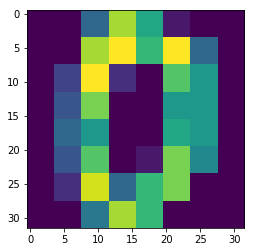

In [5]:
plt.imshow(x[0].squeeze().numpy())

### Using F.grid_sample
* https://discuss.pytorch.org/t/cropping-a-minibatch-of-images-each-image-a-bit-differently/12247/5

In [6]:
x = x.squeeze()
x.size()

torch.Size([4800, 32, 32])

In [9]:
def build_grid(source_size,target_size):
    k = float(target_size)/float(source_size)
    direct = torch.linspace(0, k, target_size).unsqueeze(0).repeat(target_size,1).unsqueeze(-1)
    full = torch.cat([direct,direct.transpose(1,0)],dim=2).unsqueeze(0)
    return full.type(torch.DoubleTensor) 


def random_crop_grid(x, grid):
    delta = x.size(2)-grid.size(1)
    grid = grid.repeat(x.size(0), 1, 1, 1)
    print('repeated grid size: {}'.format(grid.size()))
    
    #Add random shifts by x and y [4800, 4, 4]
    rand_xoff = torch.DoubleTensor(x.size(0)).random_(0, delta).unsqueeze(-1).unsqueeze(-1).expand(-1, grid.size(1), grid.size(2)) /x.size(2)
    rand_yoff = torch.DoubleTensor(x.size(0)).random_(0, delta).unsqueeze(-1).unsqueeze(-1).expand(-1, grid.size(1), grid.size(2)) /x.size(2) 
    print('rand_xoff size: {}'.format(rand_xoff.size()))
    
    grid[:,:,:,0] = grid[:, :, :, 0] + rand_xoff
    grid[:,:,:,1] = grid[:, :, :, 1] + rand_yoff
    return grid


#We want to crop a 4x4 image randomly for our batch
#Building central crop of 4 pixel size 
grid_source = build_grid(x.size(2), 4)
#Make radom shift for each batch
grid_shifted = random_crop_grid(x, grid_source)
#Sample using grid sample
sampled_batch = F.grid_sample(x.unsqueeze(2), grid_shifted)

print('Sampled batch size: {}'.format(sampled_batch.size()))

repeated grid size: torch.Size([4800, 4, 4, 2])
rand_xoff size: torch.Size([4800, 4, 4])
Sampled batch size: torch.Size([4800, 32, 4, 4])
